<br>

# 🖼️ **IMAGE CLASSIFICATION** 🖼️ 

**NEURAL NETWORKS**

## **INDEX**



- **STEP 1: PROBLEM DEFINITION AND DATA COLLECTION**
- **STEP 2: MODEL BUILDING**
- **STEP 3: MODEL TRAINNG**
- **STEP 4: OPTIMIZE THE ABOVE MODEL**
- **STEP 5: SAVE THE MODEL**

<br>

**STEP 1: PROBLEM DEFINITION AND DATA COLLECTION**

- 1.1. Problem Definition
- 1.2. Library Importing
- 1.3. Visualize the Input Information

<br>

**1.1. PROBLEM DEFINITION**

This project aims to develop a robust **image classification system** capable of distinguishing between `dog` and `cat` photos with high accuracy. The dataset for this task originates from a collaboration between Petfinder.com and Microsoft, containing a subset of 25,000 dog and cat images drawn from a much larger collection of 3 million manually annotated photos.

**Background**

- The dataset was originally used as a CAPTCHA named "Asirra," designed to differentiate humans from bots.
- User studies indicated a 99.6% success rate for humans within 30 seconds, while computers were expected to have a significantly lower success rate.
- However, a 2007 paper demonstrated an SVM-based approach achieving 80% accuracy, rendering "Asirra" unsuitable for CAPTCHA purposes.

**OUR OBJETIVE**

To build an image classification model that surpasses the state-of-the-art performance of 80% accuracy and reliably identifies dogs and cats within the provided dataset.

**Project Structure (Summary)**

1. **Data Preprocessing**
    - Download and unzip the dataset
    - Process the images
    - Create an ImageDataGenerator 

2. **Model Building**
    - Implement a CNN architecture (consider pre-trained models)
    - Define the CNN architecture with appropriate layers

3. **Model Training**
    - Train the model on the prepared training data
    - Utilize ModelCheckpoint and EarlyStopping

4. **Model Evaluation**
    - Evaluate the model's performance on the test set

5. **Model Saving**
    - Save the best performing model

<br>

**1.2. LIBRARY IMPORTING**

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


<br>

**1.3. VISUALIZE THE INPUT IMFORMATION**

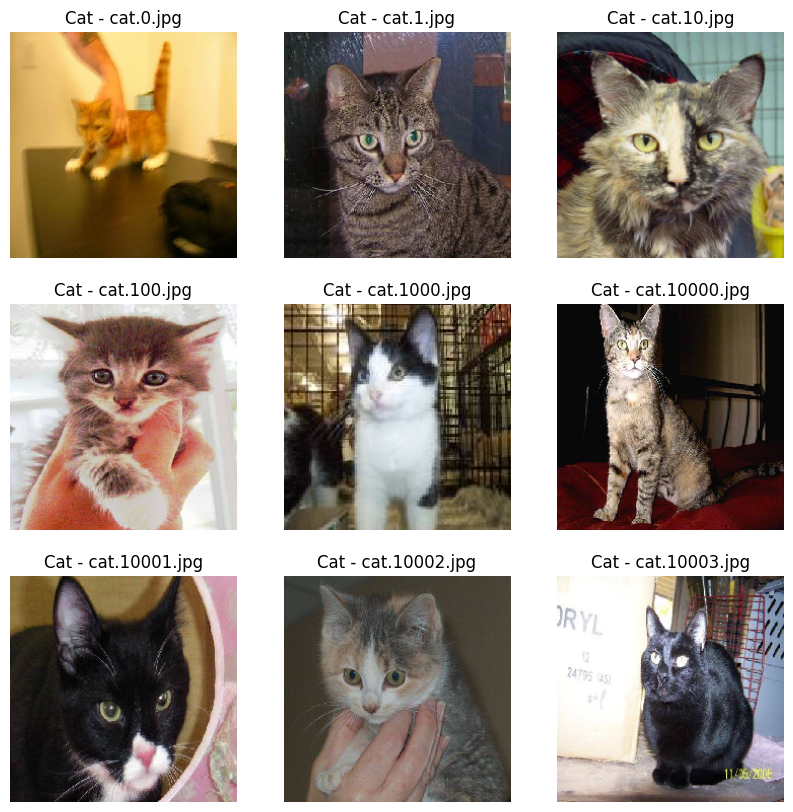

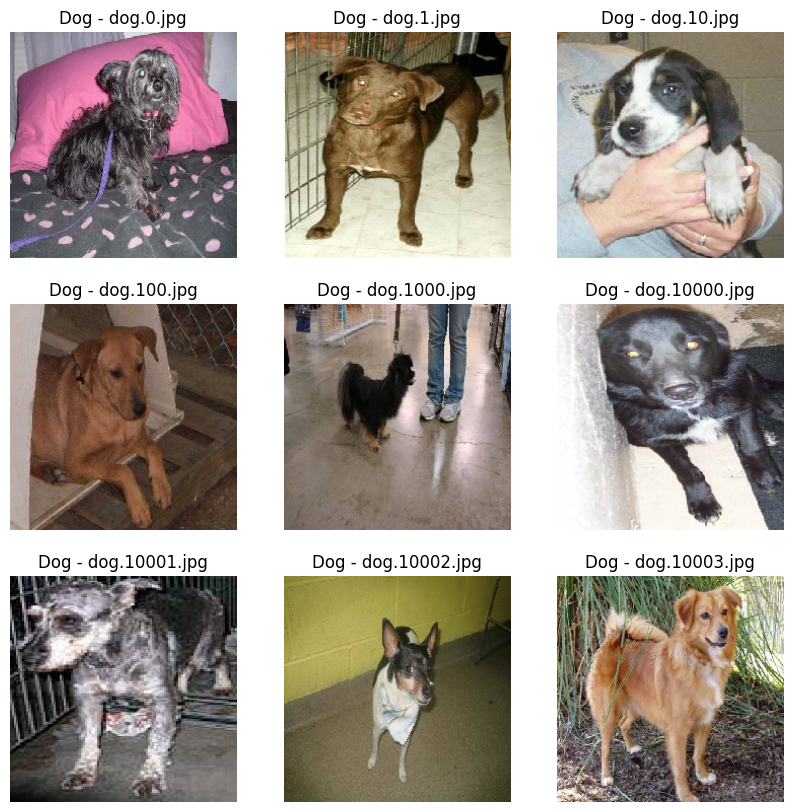

In [4]:
# Function to load images from a folder and classify them
def load_images_from_folder(folder, target_size=(224, 224), count=9, label_filter=None):
    images = []
    filenames = []
    loaded_count = 0

    # Verify if the directory exists
    if not os.path.exists(folder):
        print(f"La carpeta {folder} no existe.")
        return np.array(images), filenames

    for filename in os.listdir(folder):
        # Complete file location
        img_path = os.path.join(folder, filename)

        # Ignore folders
        if not os.path.isfile(img_path):
            continue

        # Verify the filter by category (if applicable)
        if label_filter and label_filter not in filename.lower():
            continue

        try:
            # Load and process the image
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0  # Normalización
            images.append(img_array)
            filenames.append(filename)
            loaded_count += 1

            # Stop when the required images have been loaded
            if loaded_count >= count:
                break
        except Exception as e:
            print(f"Error loading the image {img_path}: {e}")

    if not images:
        print(f"No images were found with the filter '{label_filter}' en {folder}.")
    return np.array(images), filenames

# Image grid display function
def plot_images(images, filenames, label):
    if len(images) == 0:
        print(f"No images available to show in {label}.")
        return
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(3, 3, i + 1)  # To create a 3x3 grid
        plt.imshow(img)  # Show the image
        plt.title(f"{label} - {filenames[i]}")
        plt.axis("off")  # Hide the axes
    plt.show()

# Folder path
data_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Upload and display 'cat' images
cat_images, cat_filenames = load_images_from_folder(
    os.path.join(data_dir, "cat"),  # Location of the 'cat' folder
    target_size=(224, 224),
    count=9
)
plot_images(cat_images, cat_filenames, "Cat")

# Upload and display 'dog' images
dog_images, dog_filenames = load_images_from_folder(
    os.path.join(data_dir, "dog"),  # Location of the 'dog' folder
    target_size=(224, 224),
    count=9
)
plot_images(dog_images, dog_filenames, "Dog")


<br>

<br>

- Now we are going to organize a set of images into two separate subdirectories ("cat" and "dog") based on whether their filenames contain the words "cat" or "dog". This is a common step in image classification tasks, where images need to be labeled and separated into their respective classes for training a machine learning model.

In [5]:
# Path to the 'train' folder
train_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Create subdirectories for cats and dogs images
cat_dir = os.path.join(train_dir, "cat")
dog_dir = os.path.join(train_dir, "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Moves images to subdirectories
for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)
    if os.path.isfile(file_path):  # Verify that it is a file
        if "cat" in filename.lower():  # If the name contains "cat"
            shutil.move(file_path, os.path.join(cat_dir, filename))
        elif "dog" in filename.lower():  # If the name contains "dog"
            shutil.move(file_path, os.path.join(dog_dir, filename))

print("The 'train' images are neatly structured.")


The 'train' images are neatly structured.


<br>

Let's prepare the image data for a deep learning model by:

- Reading images from a specified directory.
- Applying data augmentation techniques to increase the diversity of the training data.
- Creating generators to efficiently load batches of images during training and validation.
- Verifying the shape of a batch of images and labels to ensure correct data loading.

In [6]:
#Path to the training directory
train_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Create data generators with training and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalization
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Threshold transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest',      # Filling missing pixels
    validation_split=0.2      # Split 80/20 for training and validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),  # Fixed image size
    batch_size=32,           # Batch size
    class_mode='binary',     # Binary classification
    subset='training'        # Training set
)

# Generador para validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset='validation'      # Validation Set Generator
)

#  Verify a training batch
batch_images, batch_labels = next(train_generator)
print(f"Batch size of images: {batch_images.shape}")  # It should be a 4-dimensional array with shape (32, 200, 200, 3)
print(f"Tamaño del lote de etiquetas: {batch_labels.shape}")  #  It should be (32,)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Batch size of images: (32, 200, 200, 3)
Tamaño del lote de etiquetas: (32,)


<br>

**STEP 2. MODEL BUILDING**


- BUILD AN ANN

In [8]:
# modelo simplificado

# Model building
model = Sequential()

# Input layer (explicitly using Input to define input shape)
model.add(Input(shape=(200, 200, 3)))  # Define input shape for the model

# Block 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))  # First Conv2D layer
model.add(MaxPool2D(pool_size=(2, 2)))  # Pooling layer

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))  # First Conv2D layer in block 2
model.add(MaxPool2D(pool_size=(2, 2)))  # Pooling layer

# Block 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))  # First Conv2D layer in block 3
model.add(MaxPool2D(pool_size=(2, 2)))  # Pooling layer

# Classification
model.add(Flatten())  # Flatten the features for Dense layers
model.add(Dense(units=512, activation="relu"))  # Fully connected layer with 512 units
model.add(Dense(units=512, activation="relu"))  # Fully connected layer with 512 units
model.add(Dense(units=1, activation="sigmoid"))  # Sigmoid because it's binary classification

# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model

# Model summary
model.summary()  # Display model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,316,929 (157.61 MB)

 Trainable params: 41,316,929 (157.61 MB)

 Non-trainable params: 0 (0.00 B)

<br>

**STEP 3: MODEL TRAINING**

This part defines a convolutional neural network (CNN) architecture for binary image classification. The CNN comprises multiple convolutional layers, pooling layers, and densely connected layers.

Essentially, this code builds a CNN to classify images into two categories.

In [ ]:
# Cargar el modelo preentrenado VGG16 (sin la parte de clasificación, include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Congelar las capas del modelo base para que no se entrenen
base_model.trainable = False

# Construir el modelo
model = Sequential([
    base_model,  # Modelo preentrenado como extractor de características
    Flatten(),  # Aplanar las características para la clasificación
    Dense(512, activation='relu'),  # Capa densa personalizada
    Dropout(0.5),  # Regularización para evitar sobreajuste
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Número de épocas
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

# Guardar el modelo entrenado
model.save("cats_dogs_classifier_vgg16.h5")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,152,897 (92.14 MB)

 Trainable params: 9,438,209 (36.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.7909 - loss: 0.4345 

c:\Users\Jen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 15877s 25s/step - accuracy: 0.7910 - loss: 0.4343 - val_accuracy: 0.8852 - val_loss: 0.2686
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7352s 12s/step - accuracy: 0.8750 - loss: 0.2811 - val_accuracy: 0.8958 - val_loss: 0.2563
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7891s 13s/step - accuracy: 0.8838 - loss: 0.2667 - val_accuracy: 0.8634 - val_loss: 0.3017
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6085s 10s/step - accuracy: 0.8909 - loss: 0.2478 - val_accuracy: 0.8972 - val_loss: 0.2413
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5666s 9s/step - accuracy: 0.8935 - loss: 0.2459 - val_accuracy: 0.8984 - val_loss: 0.2366
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5524s 9s/step - accuracy: 0.8943 - loss: 0.2465 - val_accuracy: 0.8946 - val_loss: 0.2315
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7423s 12s/step - accuracy: 0.8940 - loss: 0.2405 - val_accuracy: 0.9000 - val_loss: 0.2258
Epoch 8/10
216/625 ━━━━━━━━━━━━━━━━━━━━ 47:51 7s/step - accuracy: 0.9052 - loss: 0.2158